In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score, score2


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from baseline.immnue_score import immnue_score_methods
from conceptor.utils import plot_embed_with_label,plot_performance, score

In [5]:
data_path = '../../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 111))

In [4]:
df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
#cohorts = ['Allen', 'Kim']

In [5]:
## for TIDE input
cohort_cancer_map = {'Allen': 'SKCM','Choueiri': 'KIRC', 'Gide': 'SKCM', 'Hugo': 'SKCM',
                     'IMVigor210': 'BLCA', 'IMmotion150': 'KIRC', 'Kim': 'STAD',
                     'Liu': 'SKCM', 'MGH': 'SKCM', 'Miao': 'KIRC', 'Riaz': 'SKCM', 
                     'Rose': 'BLCA', 'SU2CLC1': 'LUAD', 'SU2CLC2': 'LUSC',
                     'Snyder': 'BLCA', 'Zhao': 'GBM'}

## for NetBio input
cohort_target_map = {'Allen': 'CTLA4','Choueiri': 'PD1', 'Gide': 'PD1_CTLA4',
                     'Hugo': 'PD1', 'IMVigor210': 'PDL1', 'IMmotion150': 'PDL1',
                     'Kim': 'PD1', 'Liu': 'PD1', 'MGH':  'PD1_CTLA4',
                     'Miao': 'PD1_PDL1_CTLA4', 'Riaz': 'PD1', 'Rose': 'PD1_PDL1_CTLA4',
                     'SU2CLC1': 'PD1', 'SU2CLC2': 'PD1_PDL1_CTLA4',
                     'Snyder': 'PDL1', 'Zhao': 'PD1'}

In [8]:
def cohort_to_cohort(cohorts):
    # Create a list of lists, each missing one element from the original list
    return [(cohorts[i], cohorts[:i] + cohorts[i+1:]) for i in range(len(cohorts))]

cohorts = ['Allen', 'Kim']

train_test_cohorts = cohort_to_cohort(cohorts)

In [9]:
for train_cohort, test_cohorts in train_test_cohorts:
    train_cohort, test_cohorts

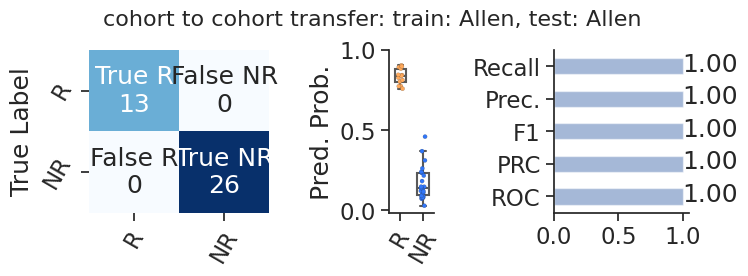

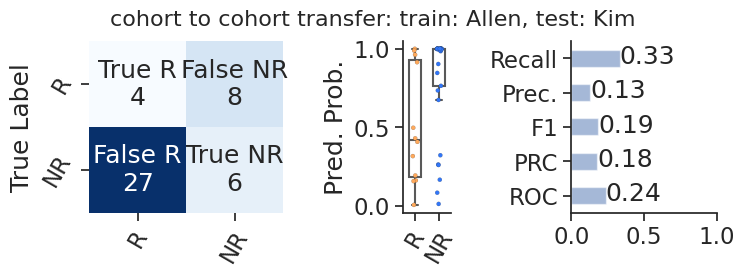

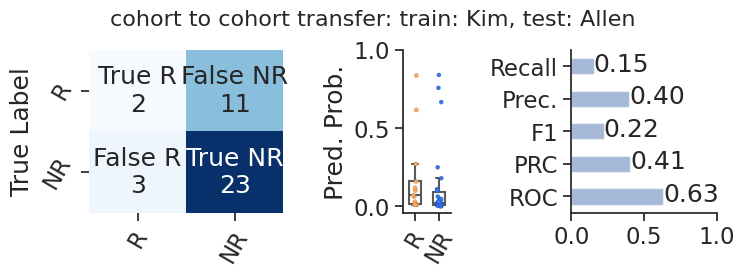

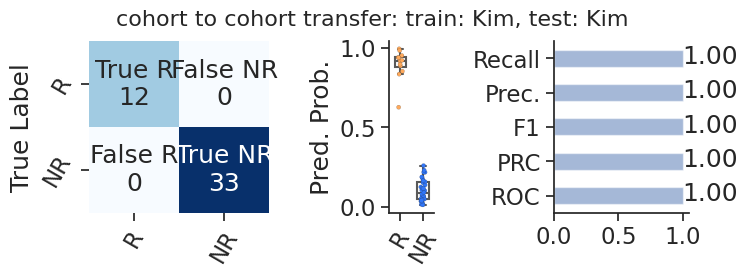

In [10]:
mode = 'NetBio'

work_dir = './tmpignore/CTCT_%s_test' % (mode)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

res = []

for train_cohort, test_cohorts in train_test_cohorts:
    
    ## Get data for this cohort
    cohort_idx = df_label[df_label['cohort'] == train_cohort].index
    cohort_X = df_tpm.loc[cohort_idx]
    cohort_y = df_task.loc[cohort_idx]
    
    ## Get features for specific method
    cohort_target = cohort_target_map[train_cohort]
    cohort_cancer_type = cohort_cancer_map[train_cohort]
    Extractor = immnue_score_methods[mode]
    E = Extractor(cancer_type=cohort_cancer_type, drug_target=cohort_target)
    cohort_dfx = E(cohort_X)
    cohort_dfy = cohort_y['R']

    data_scaler = StandardScaler()
    train_X = data_scaler.fit_transform(cohort_dfx)
    train_y = cohort_dfy.values
    
    param_grid = {'penalty':['l2'], 'max_iter':[int(1e10)], 'solver':['lbfgs'],
                  'C':np.arange(0.1, 1, 0.1), 'class_weight':['balanced'] }
    model = LogisticRegression()
    
    gcv = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1).fit(train_X, train_y)
    best_C = gcv.best_params_['C']

    for test_cohort in cohorts:
        test_cohort_idx = df_label[df_label['cohort'] == test_cohort].index
        test_cohort_X = df_tpm.loc[test_cohort_idx]
        test_cohort_y = df_task.loc[test_cohort_idx]
        
        test_cohort_dfx = E(test_cohort_X)
        test_cohort_dfy = test_cohort_y['R']
        test_X = data_scaler.transform(test_cohort_dfx)
        
        pred_prob = gcv.best_estimator_.predict_proba(test_X)
        
        pred_testy = pd.DataFrame(pred_prob, index = test_cohort_dfy.index)
        pred_testy['train_cohort'] = train_cohort
        pred_testy['test_cohort'] = test_cohort    
        pred_testy['best_C'] = best_C
        pred_testy['mode'] = mode
        dfp = test_cohort_y.join(pred_testy)

        y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
        fig = plot_performance(y_true, y_prob, y_pred)
        fig.suptitle('cohort to cohort transfer: train: %s, test: %s' % (train_cohort, test_cohort), fontsize=16)
        fig.savefig(os.path.join(work_dir, 'CTCT_train_%s_test_%s.jpg' % (train_cohort, test_cohort)))

        res.append(dfp)

dfs = pd.concat(res)
dfp = dfs.groupby(['train_cohort', 'test_cohort']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))
mode_map = dfs.groupby('train_cohort')['mode'].unique().apply(lambda x:x[0])
c_map = dfs.groupby('train_cohort')['best_C'].unique().apply(lambda x:x[0])

#roc, prc, f1, acc, mcc
dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
dfp = dfp.reset_index()
dfp['mode'] = dfp.train_cohort.map(mode_map)
dfp['best_C'] = dfp.train_cohort.map(c_map)

dfs.to_csv(os.path.join(work_dir, 'source_performance.tsv'), sep='\t')
dfp.to_csv(os.path.join(work_dir, 'metric_performance.tsv'), sep='\t')

<Axes: xlabel='test_cohort', ylabel='train_cohort'>

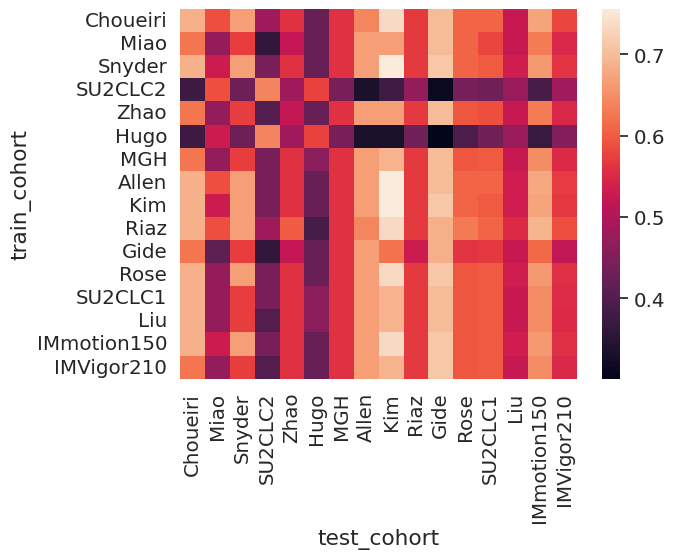

In [194]:
df_mcc = pd.pivot_table(dfp, index='train_cohort', columns='test_cohort', values = 'ACC')
df_mcc = df_mcc.loc[cohorts][cohorts]
sns.heatmap(df_mcc)

In [196]:
df_mcc

test_cohort,Choueiri,Miao,Snyder,SU2CLC2,Zhao,Hugo,MGH,Allen,Kim,Riaz,Gide,Rose,SU2CLC1,Liu,IMmotion150,IMVigor210
train_cohort,,,,,,,,,,,,,,,,
Choueiri,0.6875,0.588235,0.666667,0.48,0.56,0.423077,0.558824,0.641026,0.733333,0.568627,0.698630,0.606742,0.607843,0.523364,0.672727,0.580537
Miao,0.6250,0.470588,0.571429,0.36,0.52,0.423077,0.558824,0.666667,0.666667,0.568627,0.698630,0.606742,0.578431,0.523364,0.630303,0.546980
Snyder,0.6875,0.529412,0.666667,0.44,0.56,0.423077,0.558824,0.666667,0.755556,0.568627,0.712329,0.606742,0.598039,0.532710,0.660606,0.563758
SU2CLC2,0.3750,0.588235,0.428571,0.64,0.48,0.576923,0.441176,0.333333,0.377778,0.470588,0.315068,0.438202,0.431373,0.476636,0.387879,0.483221
Zhao,0.6250,0.470588,0.571429,0.40,0.52,0.423077,0.558824,0.666667,0.666667,0.568627,0.698630,0.595506,0.588235,0.523364,0.630303,0.546980
Hugo,0.3750,0.529412,0.428571,0.64,0.48,0.576923,0.441176,0.333333,0.333333,0.431373,0.301370,0.393258,0.431373,0.476636,0.369697,0.453020
MGH,0.6250,0.470588,0.571429,0.44,0.56,0.461538,0.558824,0.666667,0.688889,0.568627,0.698630,0.595506,0.598039,0.523364,0.648485,0.550336
Allen,0.6875,0.588235,0.666667,0.44,0.56,0.423077,0.558824,0.666667,0.755556,0.568627,0.698630,0.606742,0.607843,0.532710,0.678788,0.570470
Kim,0.6875,0.529412,0.666667,0.44,0.56,0.423077,0.558824,0.666667,0.755556,0.568627,0.712329,0.606742,0.598039,0.532710,0.672727,0.567114


[Text(0, 0, 'Choueiri'),
 Text(1, 0, 'Miao'),
 Text(2, 0, 'Snyder'),
 Text(3, 0, 'SU2CLC2'),
 Text(4, 0, 'Zhao'),
 Text(5, 0, 'Hugo'),
 Text(6, 0, 'MGH'),
 Text(7, 0, 'Allen'),
 Text(8, 0, 'Kim'),
 Text(9, 0, 'Riaz'),
 Text(10, 0, 'Gide'),
 Text(11, 0, 'Rose'),
 Text(12, 0, 'SU2CLC1'),
 Text(13, 0, 'Liu'),
 Text(14, 0, 'IMmotion150'),
 Text(15, 0, 'IMVigor210')]

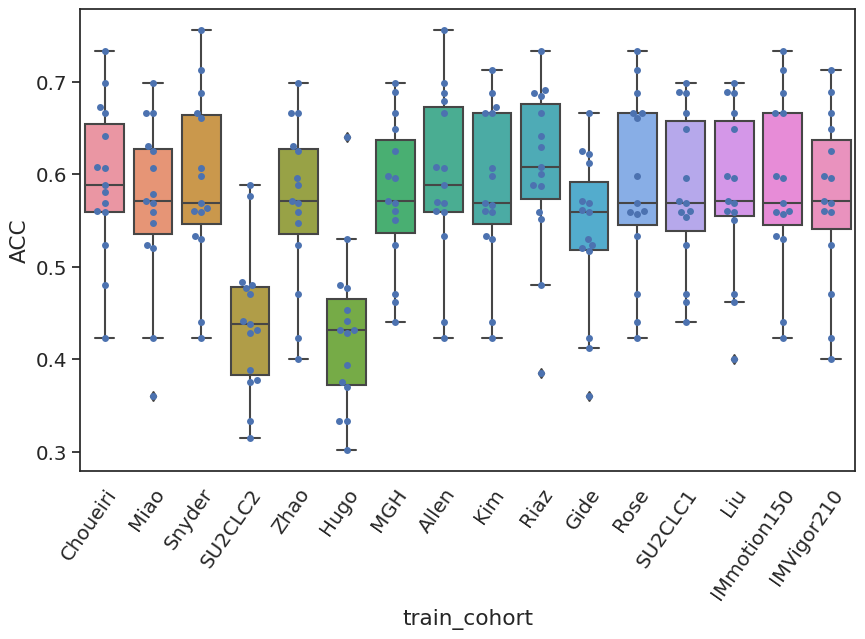

In [184]:
dfp1 =  dfp[dfp.train_cohort != dfp.test_cohort]
fig, ax = plt.subplots(figsize=(10, 6))

x = 'train_cohort'
y = 'ACC'
x_order = cohorts #dfp1.groupby(x)[y].mean().sort_values().index.tolist()


sns.swarmplot(data = dfp1,x= x, y = y, ax=ax, order = x_order)
sns.boxplot(data = dfp1,x= x, y = y, ax=ax, order = x_order)

ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)

ax.set_xticklabels(
    x_order, 
    rotation=55, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
